In [80]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import datetime as dt

from sentinelhub import (
    SHConfig,
    MimeType,
    CRS,
    BBox,
    SentinelHubRequest,
    SentinelHubDownloadClient,
    DataCollection,
    bbox_to_dimensions,
    DownloadRequest,
    Geometry,
    filter_times,
    MosaickingOrder,
    SentinelHubCatalog
)

import sh_credentials
from utils import plot_image

In [81]:
#Connect to Sentinel Hub
config = SHConfig()

#Use sh_credentials in the config
config.instance_id = sh_credentials.instance_id
config.sh_client_id = sh_credentials.sh_client_id
config.sh_client_secret = sh_credentials.sh_client_secret

In [83]:
#Read in the feedlot sample kml
file_path = "../Data/porcupine_mountains.geojson"
bwca_gdf = gpd.read_file(file_path)

In [84]:
#look at the boundary
bwca_gdf

,geometry
0,"POLYGON ((-89.99725 46.65085, -89.61342 46.650..."


In [85]:
#Make into Sentinelhub geometry object
bwca_geometry = Geometry(bwca_gdf.geometry.values[0], crs = CRS.WGS84)
bwca_geometry

Geometry(POLYGON ((-89.99725341796874 46.6508502096111, -89.61341857910156 46.6508502096111, -89.61341857910156 46.880845705719146, -89.99725341796874 46.880845705719146, -89.99725341796874 46.6508502096111)), crs=CRS('4326'))

In [97]:
#create bbox
resolution = 15
aoi_bbox = bwca_geometry.bbox
aoi_size = bbox_to_dimensions(aoi_bbox, resolution = resolution)

print(f"Image shape at {resolution} m resolution: {aoi_size} pixels")

Image shape at 15 m resolution: (2015, 1634) pixels


In [212]:
#Setting up the catolog
from time import time_ns

catalog = SentinelHubCatalog(config=config)

#Selecting Time interval
time_interval = ("2021-06-15", "2021-06-30")

#searching the catalog for all images
search_iterator = catalog.search(
    DataCollection.SENTINEL2_L2A,
    bbox = aoi_bbox,
    time = time_interval,
    query = {"eo:cloud_cover": {"lt":5}},
    fields={"include":["id","properties.datetime","properties.eo:cloud_cover"], "exclude": []},
)

results = list(search_iterator)
print("Total number of results: ", len(results))

#Get all unique timestamps
time_difference = dt.timedelta(hours =24)

all_timestamps = search_iterator.get_timestamps()
unique_acquistions = filter_times(all_timestamps, time_difference)

[print(date_time.strftime(r"%Y-%m-%d")) for date_time in unique_acquistions]
print("")

Total number of results:  3
2021-06-15
2021-06-25



In [213]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            },
            mosaicking: "SIMPLE"
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

#create list for all requests
process_requests = []

for timestamp in unique_acquistions:
    request_true_color = SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=(timestamp.date(),timestamp.date() + time_difference),
                mosaicking_order=MosaickingOrder.LEAST_CC
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        geometry = bwca_geometry,
        bbox= aoi_bbox,
        size= aoi_size,
        config= config,
    )
    process_requests.append(request_true_color)


client = SentinelHubDownloadClient(config = config)
download_requests = [request.download_list[0] for request in process_requests]

#downloading
data = client.download(download_requests)

In [214]:
len(data)

2

In [215]:
data[0].shape

(1634, 2015, 3)

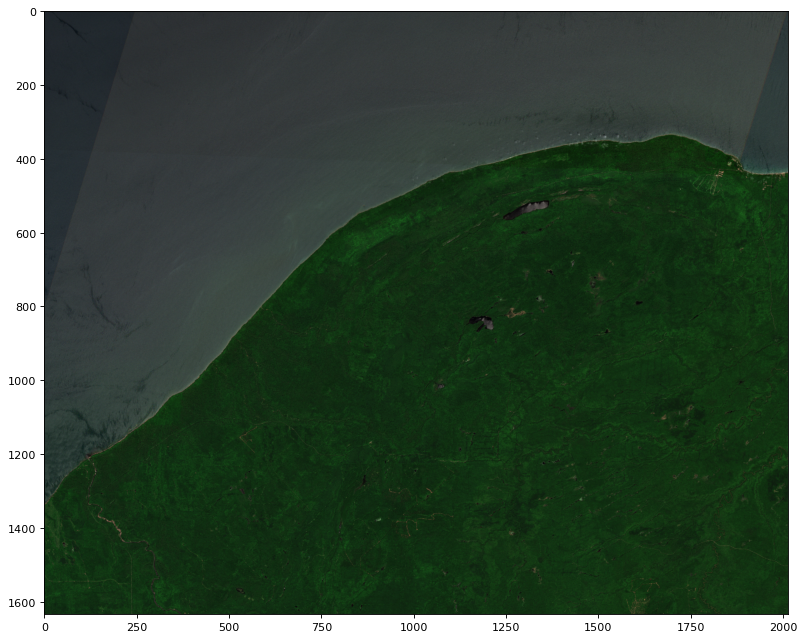

In [218]:
normalized_img = np.clip(data[0]*4/255, 0, 1)
plt.figure(num=None, figsize=(12,12), dpi = 80)
plt.imshow(normalized_img)